## Embedded Faults (interface2d) : particle density and smoothing


In the context of a 2D continuum flow model, an embedded fault is a 1d line (based on on an Underworld2 swarm object) that we advect with the flow, and can be used to maintain and constrain a finite region of distinct material properties.

Interface2D objects are advected using the standard parallel swarm advecting routines. During model evolution, it is likely that the embedded fault swarm will become less smooth and/or loose particle density. 


UW2 does not have functionality for managing the density or smoothness of 1D swarm objects, so we introduce some functionality for doing that. The smoothing is based on estimated a Laplacian operator (curvature) for the particles in the embedded fault.



* Note that much of this functionality is not well tested. Some safeguards have been put in place for parallel operation, but problems are still likely to emerge.

In [49]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
import operator
import UWsubduction as usub
from UWsubduction.interfaces.smoothing2D import *

In [34]:

resX = 12
resY = 12
elementType="Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( -0.5, -0.5), 
                                 maxCoord    = ( 0.5, 0.5)  ) 


velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )

velocityField.data[:] = [0.,0.]


In [35]:
coordinate = fn.input()
yFn = coordinate[1]

In [36]:
velocityField.data[:,0] = 2.*yFn.evaluate(mesh)[:,0] #dVx/dy = 1
velocityField.data[:,1] = 0.

In [37]:
swarm = uw.swarm.Swarm( mesh=mesh, particleEscape=False)
proximityVariable = swarm.add_variable( dataType="int", count=1 )
directorVariable   = swarm.add_variable( dataType="double", count=2)

swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

proximityVariable.data[:] = 0
directorVariable .data[:] = (0.0, 0.0)

In [40]:
#Set up some embedded faults (interface2D) with npisy data

ds = 1./50

np.random.seed = 1
markerXs = np.arange(-0.5, 0.5, ds) + 0.02*np.random.rand(50)
markerYs = 0.2*np.sin(2.*np.pi*markerXs) + 0.05*np.sin(8.*np.pi*markerXs) + 0.01*np.random.rand(50)


markerThickness = 0.1

ef1 = usub.interface2D(mesh, velocityField, markerXs, markerYs, 
                        markerThickness, 1, insidePt=(0.,-10.))




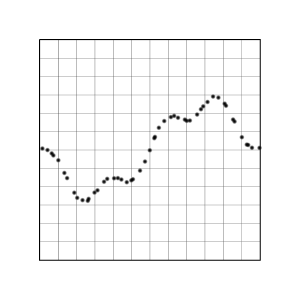

In [41]:
fig1 = glucifer.Figure(figsize=(300,300))
fig1.append(glucifer.objects.Mesh(mesh, opacity= 0.4))
fig1.append( glucifer.objects.Points(ef1.swarm, pointsize = 5))

fig1.show()

## Repair interface2d

The following function will add / remove particles to try to maintain spacing (provided by `ds`)

it will also apply a Laplacian smoothing operation, which can be controlled by arguments:

* _lambda
* smoothCycles
* laplaceLimit = 0.25 

In [54]:
help(usub.interfaces.repair_interface2D)

Help on function repair_interface2D in module UWsubduction.interfaces.smoothing2D:

repair_interface2D(interface2D, ds, smoothCycles=1, k=4, _lambda=0.5, laplaceLimit=0.25)
    smoothCycles ...
    k = max number of particles to search for neighbour information
    _lambda = 0.5         #A dampening  applied to the entire laplacian vector
    laplaceLimit = 0.25   #fraction of inter-particle distance that is the maximum laplace displacement



In [55]:
#run this function to repair the embedded fault
usub.interfaces.repair_interface2D(ef1, ds, smoothCycles=5, k=8)


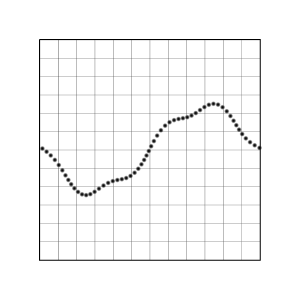

In [56]:
fig2 = glucifer.Figure(figsize=(300,300))
fig2.append(glucifer.objects.Mesh(mesh, opacity= 0.4))
fig2.append( glucifer.objects.Points(ef1.swarm, pointsize = 5))

fig2.show()